# Classification of Curiosity Rover Images from Mars

## Introduction

The purpose of this analysis is to create a model, or models, for classifying images from the surface of Mars. If effective, this could save countless hours of individual image identification by humans. It also may inform a usable type of model architecture for classifying other datasets of astronomical images.
</br></br>
The data used in this analysis are approximately 6700 images taken of the Martian terrain by the Curiosity Rover from August 2012 to July 2015.
</br></br>
The dataset can be found [here](https://zenodo.org/records/1049137 "Visit Zenodo").

## Import Libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns
from PIL import Image
import os
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

## Load Data
- The images are stored in a sorted folder while the labels are stored in three files with random ordering. Care will need to be taken while loading to ensure proper matching of the images with their respective labels.
- There are 6737 images in total and only 6691 labels. This will need to be accounted for as well.

In [2]:
# File containing the legend for describing the labels
labels = pd.read_fwf('msl_synset_words-indexed.txt', sep=' ', header=None)
labels.rename(columns={0:'Label', 1:'Description'}, inplace=True)

In [3]:
# Randomized training labels
train_shuffled = pd.read_fwf('train-calibrated-shuffled.txt', sep=' ', header=None)
train_shuffled.rename(columns={0:'Filename', 1:'Label'}, inplace=True)

# Remove 'calibrated/' from the file name as the folder path will be specified on loading
train_shuffled['Filename'] = train_shuffled['Filename'].str[11:]

In [4]:
# Randomized validation labels
val_shuffled = pd.read_fwf('val-calibrated-shuffled.txt', sep=' ', header=None)
val_shuffled.rename(columns={0:'Filename', 1:'Label'}, inplace=True)
val_shuffled['Filename'] = val_shuffled['Filename'].str[11:]

In [5]:
# Randomized testing labels
test_shuffled = pd.read_fwf('test-calibrated-shuffled.txt', sep=' ', header=None)
test_shuffled.rename(columns={0:'Filename', 1:'Label'}, inplace=True)
test_shuffled['Filename'] = test_shuffled['Filename'].str[11:]

In [6]:
# Concatenate all labels and add descriptions, totaling 6691
concat = pd.concat([train_shuffled, val_shuffled, test_shuffled]).reset_index(drop=True)
key = concat.merge(labels, how='left', on='Label')

In [7]:
# Read all filenames in image folder, merge labels for filenames with an associated label
filenames = pd.DataFrame(os.listdir('calibrated'))
filenames.rename(columns={0:'Filename'}, inplace=True)
filenames = filenames.merge(key, how='left', on='Filename')

In [8]:
# Create df for indexing purposes with files dropped that have no label
dropped = filenames.dropna()

# Use missing indices to identify unlabeled filenames
unlabeled = filenames[~filenames.index.isin(dropped.index)]

In [9]:
# Folder containing image files
folder_path = "calibrated"

# Create lists of labeled and unlabeled image filenames
labeled_files = concat['Filename'].tolist()
unlabeled_files = unlabeled['Filename'].tolist()

# Load images
images_color = [Image.open(os.path.join(folder_path, file)) for file in labeled_files]
images_color_unlabeled = [Image.open(os.path.join(folder_path, file)) for file in unlabeled_files]

## Data Exploration

In [10]:
# Check that there are 6691 labeled images
len(images_color)

6691

In [11]:
# View quantity of unlabeled images
len(images_color_unlabeled)

46

In [12]:
# Double check everything was loaded properly and the numbers match
len(filenames) == len(images_color) + len(images_color_unlabeled)

True

In [13]:
# View the labels and descriptions
labels

Label           Description
0       0                  apxs
1       1       apxs cal target
2       2    chemcam cal target
3       3     chemin inlet open
4       4                 drill
5       5           drill holes
6       6             drt front
7       7              drt side
8       8                ground
9       9               horizon
10     10                 inlet
11     11                 mahli
12     12      mahli cal target
13     13               mastcam
14     14    mastcam cal target
15     15      observation tray
16     16           portion box
17     17          portion tube
18     18  portion tube opening
19     19        rems uv sensor
20     20       rover rear deck
21     21                 scoop
22     22                   sun
23     23                turret
24     24                 wheel

In [14]:
# Check if all labels are represented in each data split
tr, vl, ts = train_shuffled['Label'].nunique(), val_shuffled['Label'].nunique(), test_shuffled['Label'].nunique()
print(f'Total number of unique labels:     {len(labels)}')
print(f'Unique labels in training split:   {tr}')
print(f'Unique labels in validation split: {vl}')
print(f'Unique labels in testing split:    {ts}')

Total number of unique labels:     25
Unique labels in training split:   24
Unique labels in validation split: 20
Unique labels in testing split:    22


- Not quite. There is one label missing from the training split, so the models won't be trained on that label. Additional image types are missing from both the validation and testing sets.

Text(0.5, 1.0, 'Image Counts by Label Name')

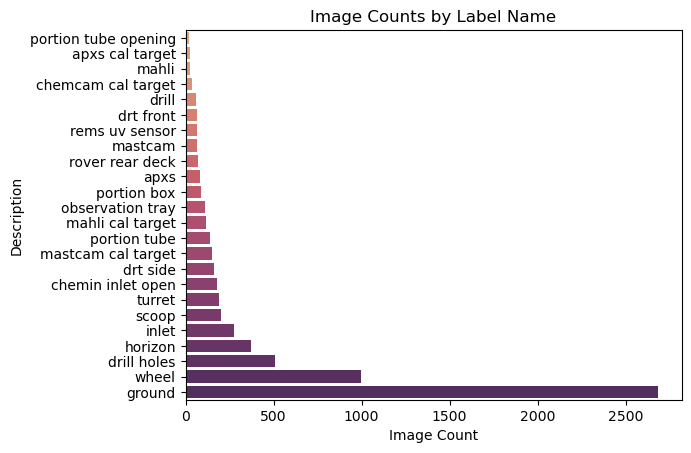

In [15]:
# See how the images are distributed among labels
label_counts = pd.DataFrame(key['Description'].value_counts()).reset_index().sort_values(by='Description', axis=0)
label_counts = label_counts.rename(columns={'Description':'Image Count', 'index':'Description'})
sns.barplot(label_counts, x='Image Count', y='Description', palette='flare').set_title('Image Counts by Label Name')

- There are by far more images of the ground than any other image type.
- 'Sun' is listed as an image label, but none appear in the data. That must be the missing label of note from the training split, but it appears to be missing entirely from the dataset.
- The data are more evenly distributed between the surroundings and the rover than this plot may suggest.

Text(1, 3130, '3130')

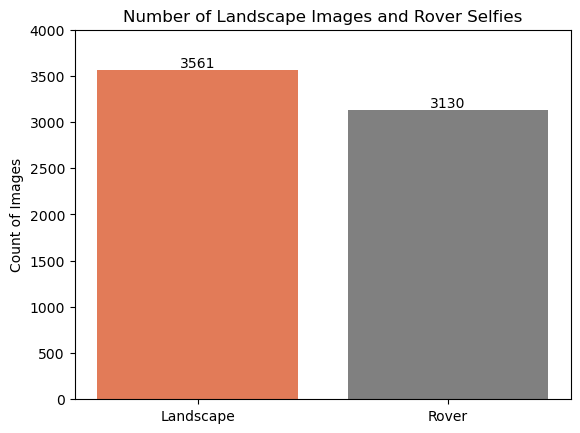

In [16]:
# Get counts of rover and landscape images
landscape = label_counts['Image Count'][0]+label_counts['Image Count'][2]+label_counts['Image Count'][3]
rover = sum(label_counts['Image Count'])-(label_counts['Image Count'][0]+label_counts['Image Count'][2]+label_counts['Image Count'][3])

# Plot
plt.bar(['Landscape', 'Rover'], [landscape, rover], color=['#E27B58', '#808080'])
plt.title('Number of Landscape Images and Rover Selfies')
plt.ylabel('Count of Images')
plt.ylim(0,4000)
plt.text(0, landscape, str(landscape), ha='center', va='bottom')
plt.text(1, rover, str(rover), ha='center', va='bottom')

Text(0.5, 1.0, 'Image Dimensions')

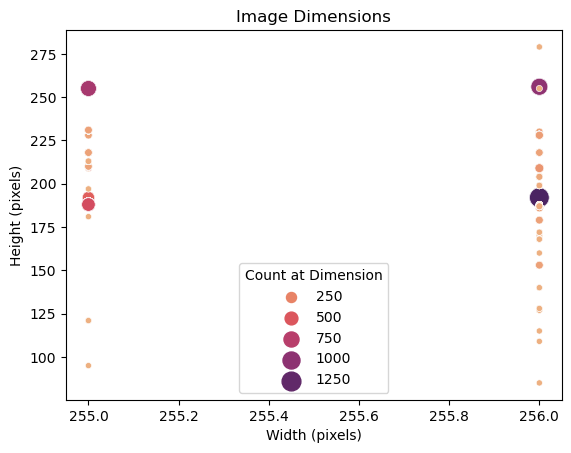

In [17]:
# Plot image sizes
w = []
h = []
for img in images_color:
    w.append(img.width)
    h.append(img.height)
img_dims = pd.DataFrame({'Width (pixels)':w, 'Height (pixels)':h})
dims_grouped = img_dims.groupby(['Width (pixels)', 'Height (pixels)']).size().reset_index(name='Count at Dimension')
dims_merged = img_dims.merge(dims_grouped, on=['Width (pixels)', 'Height (pixels)'])
sns.scatterplot(dims_merged, x='Width (pixels)', y='Height (pixels)', size='Count at Dimension',
                sizes=(20, 200), hue='Count at Dimension', palette='flare').set_title('Image Dimensions')

In [18]:
unique_dims = img_dims[['Width (pixels)', 'Height (pixels)']].apply(tuple, axis=1).nunique()

print(f'Number of unique image sizes: {unique_dims}')
print()
print(f'Unique width values:          {len(set(w))}')
print(f'Minimum width value:          {min(w)}')
print(f'Maximum width value:          {max(w)}')
print(f'Maximum difference in width:  {max(w)-min(w)}')
print()
print(f'Unique height values:         {len(set(h))}')
print(f'Minimum height value:         {min(h)}')
print(f'Maximum height value:         {max(h)}')
print(f'Maximum difference in height: {max(h)-min(h)}')

Number of unique image sizes: 42

Unique width values:          2
Minimum width value:          255
Maximum width value:          256
Maximum difference in width:  1

Unique height values:         34
Minimum height value:         85
Maximum height value:         279
Maximum difference in height: 194


- The images are not a consistent size, with 42 different image shapes. Most fall into about 5 similar sizes, as can be seen from the densities in the plot.
- There are two different width values with only a one pixel difference between them.
- Height is where most of the variance lies. There are 34 unique height values that span from 85 pixels to 279 pixels, a difference of 194 pixels.

- Now to view some of the images

In [19]:
# Define a function to easily plot images
# Include the ability to skip through the images by a chosen factor
def plot_images(df, num_images=12, skip_by=1, cmap=None):
    
    # Prevent index from exceeding range, subscripting errors
    if num_images > len(df):
        num_images = len(df)
        
    if num_images*skip_by > len(df):
        skip_by = math.floor(len(df) / num_images)
        
    if num_images < 2:
        print('Error: Minimum images to show is two')
        num_images = 2
    
    # Calculate the number of rows and columns for the subplot grid
    num_rows = math.ceil(num_images / 4)
    num_cols = min(num_images, 4)
    
    # Create a grid of subplots to match number of images desired
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3*num_rows), subplot_kw={'xticks':[], 'yticks':[]})
    
    # Flatten the axes array if it's more than 1D
    axes = axes.flatten()
    
    # Display the images and set titles
    for i in range(num_images):
        j = i * skip_by
        if i < len(df):
            axes[i].imshow(df[j], cmap=cmap)
            axes[i].set_title(f'Image {j + 1}')
    
    # Remove any empty subplots
    for i in range(num_images, len(axes)):
        fig.delaxes(axes[i])
        
    plt.tight_layout()
    plt.show()

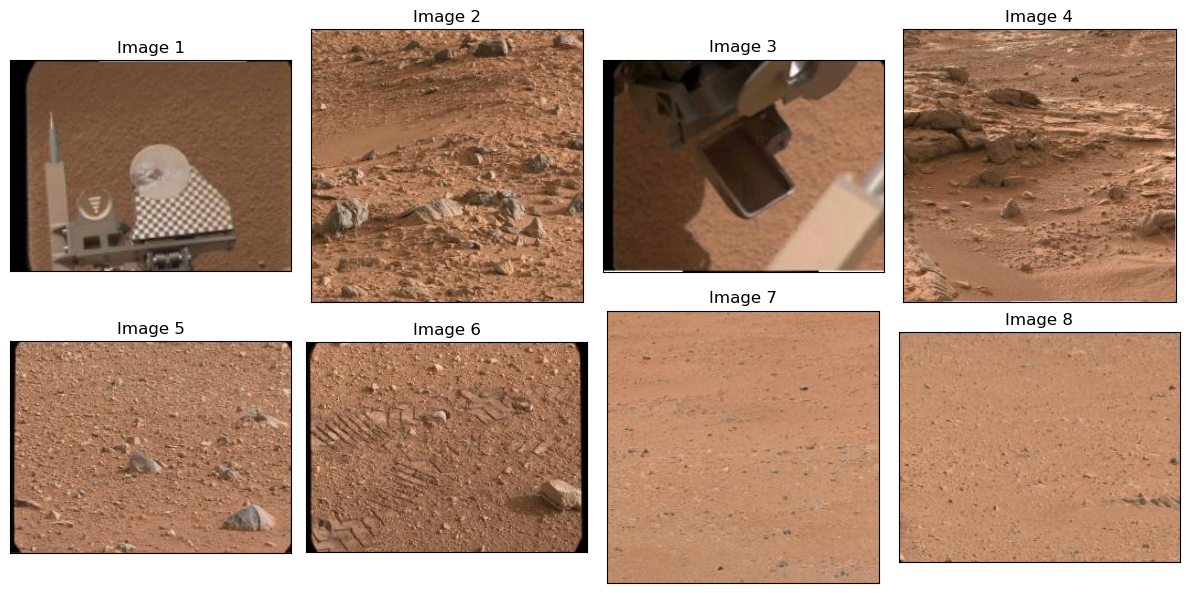

In [20]:
# View first 8 images
plot_images(images_color, 8)

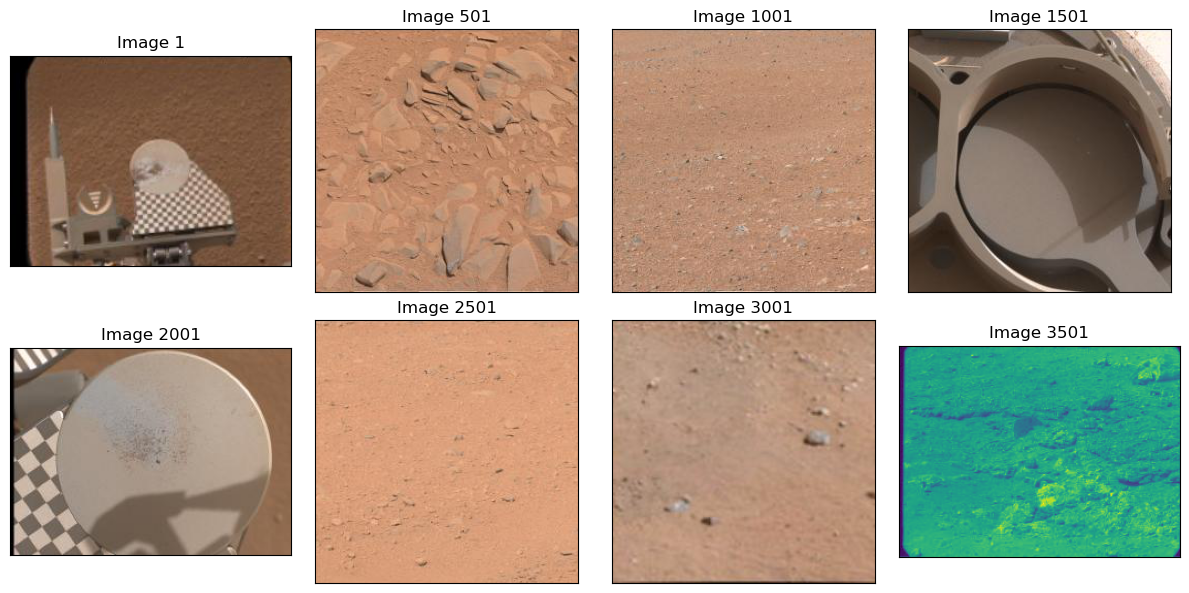

In [21]:
# View 8 again, skipping by 500
plot_images(images_color, 8, 500)

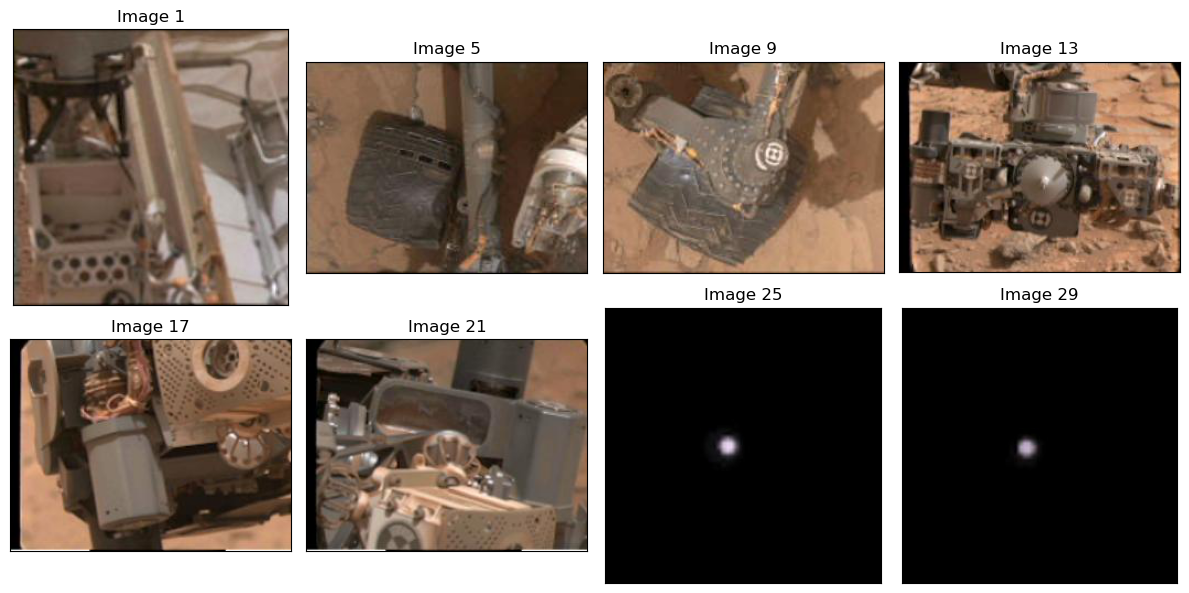

In [22]:
# Now the unlabeled images, skipping by 4
plot_images(images_color_unlabeled, 8, 4)

- It appears the missing images of the sun have been found.

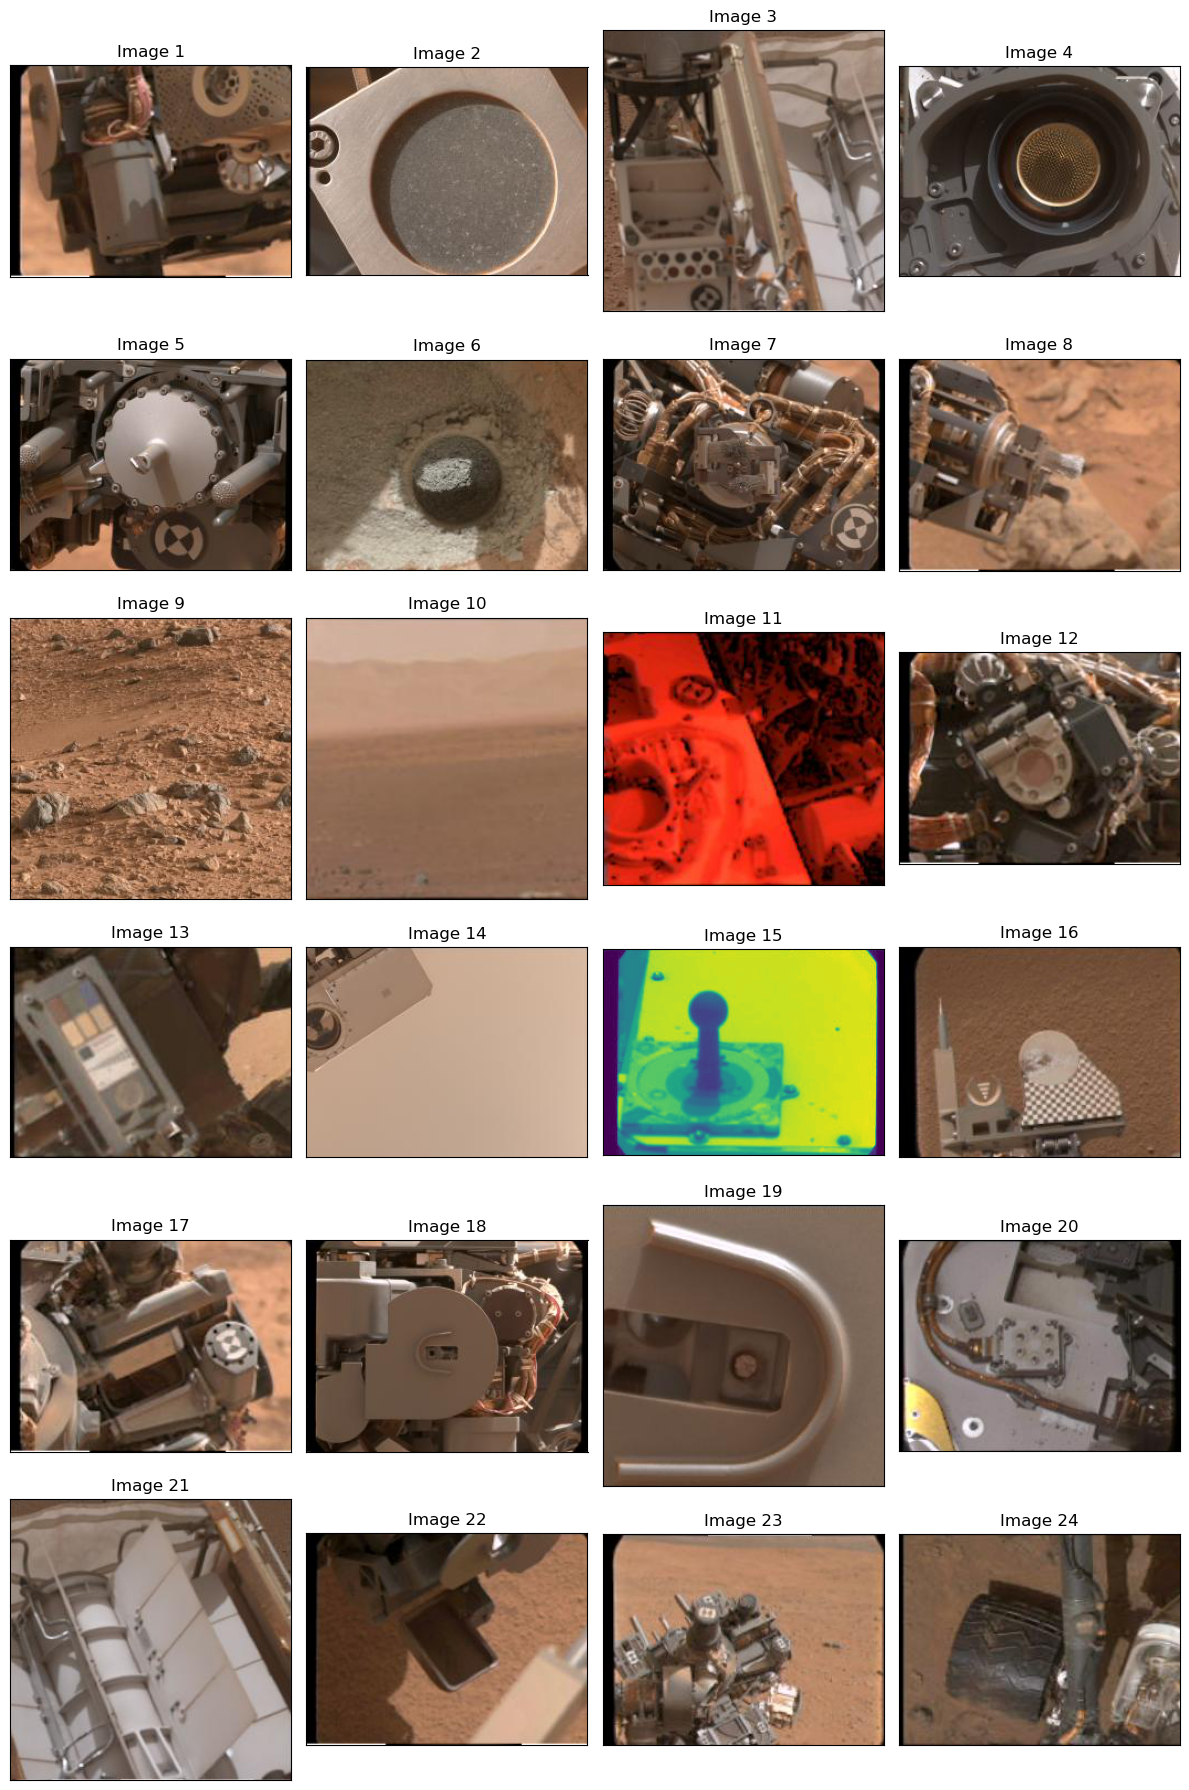

In [23]:
# View a representative image for each image type (not including sun)
valid_labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24]
imgs = []
for i in valid_labels:
    indices = key[key['Label'] == i].index
    images = [images_color[j] for j in indices]
    imgs.append(images[0])
plot_images(imgs, len(imgs))

## Preprocessing

- Given that Mars is essentially monochromatic, little information is gained by preserving the images in their original RGB state, so the images can be transformed to grayscale for computational efficiency.
- Additionally, this must be performed regardless because all images must have the same dimensions when fed into the models, and the dataset contains some grayscale images already (see image 3501 above, shown in matplotlib's default 'Viridis' color scheme for grayscale images) that lack the information necessary to be expanded into the 3-Dimensional RGB space.

In [24]:
# Create a function for color conversion
def rgb2gray(rgb):
    grayscale_images = []
    for img in rgb:
        grayscale_img = img.convert('L')  # Convert to grayscale
        grayscale_images.append(grayscale_img)
        
    return grayscale_images

- As mentioned above, dimensionality must be consistent, including for the width and height of the images. For this, the images will be resized to 224x224. The size was chosen based on results from the convolutional neural network later in this analysis.

In [25]:
def resize(data, width, height):
    resized_images = []
    for img in data:
        resized_images.append(img.resize((width, height)))
    return resized_images

- The images will also need to be converted from the PIL objects into arrays.

In [26]:
def make_array(data):
    arr = []
    for i in data:
        arr.append(np.array(i))
        
    return np.array(arr)

In [27]:
# Convert images to resized grayscale arrays
images_gray_PIL = rgb2gray(images_color)
images_resized = resize(images_gray_PIL, 224, 224)
images_prepared = make_array(images_resized)

# Do the same for the unlabeled images
images_gray_unlabeled_PIL = rgb2gray(images_color_unlabeled)
images_resized_unlabeled = resize(images_gray_unlabeled_PIL, 224, 224)
images_prepared_unlabeled = make_array(images_resized_unlabeled)

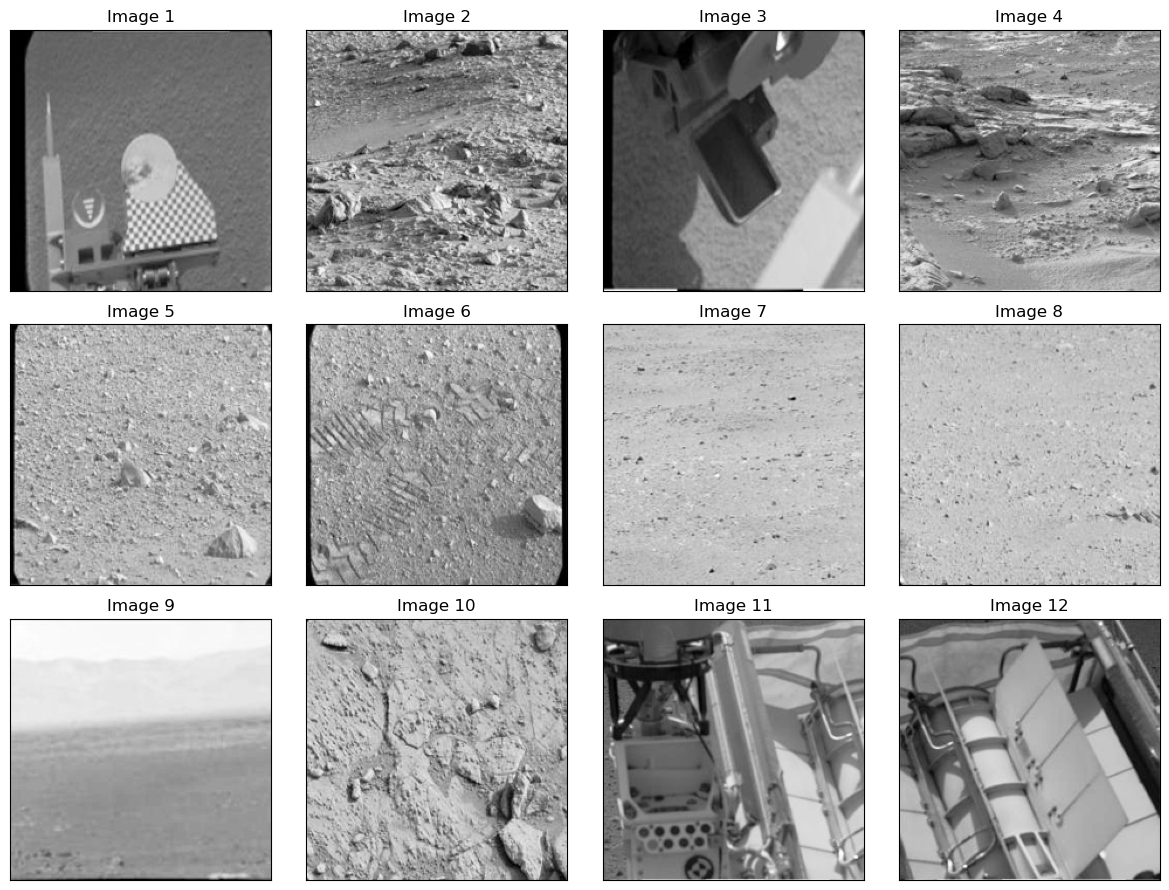

In [28]:
# View some of the transformed images
plot_images(images_prepared, cmap='Greys_r')

- Now to split the data.

In [29]:
# Split images into training, validation, and testing sets, and rescale data between 0 and 1
X_train = images_prepared[:len(train_shuffled)] / 255
X_valid = images_prepared[len(train_shuffled):len(train_shuffled) + len(val_shuffled)] / 255
X_test = images_prepared[len(train_shuffled) + len(val_shuffled):] / 255

# And for labels
y_train = train_shuffled['Label']
y_valid = val_shuffled['Label']
y_test = test_shuffled['Label']

## Clustering with K-means

- Unsupervised learning with K-means will be the first task, to see how well the data can be grouped without the help of the labels.
- The value of k will be set to the number of labels that exist in the training dataset, 24.
- Ideally, the model will be able to identify similarities in the pixel values across the images, and assign them to clusters with a distribution that resembles the input data.

In [30]:
# Reshape Data 
X_train_2D = X_train.reshape(X_train.shape[0], -1)
X_valid_2D = X_valid.reshape(X_valid.shape[0], -1)
X_test_2D = X_test.reshape(X_test.shape[0], -1)

In [31]:
# Value of k for number of clusters
k = 24

# Instantiate the model, fit, and predict
kmeans = KMeans(n_clusters=k, random_state=42)
k_fit = kmeans.fit(X_train_2D)
k_pred = k_fit.predict(X_train_2D)

Text(0.5, 1.0, 'Predicted Image Counts by Assigned Cluster')

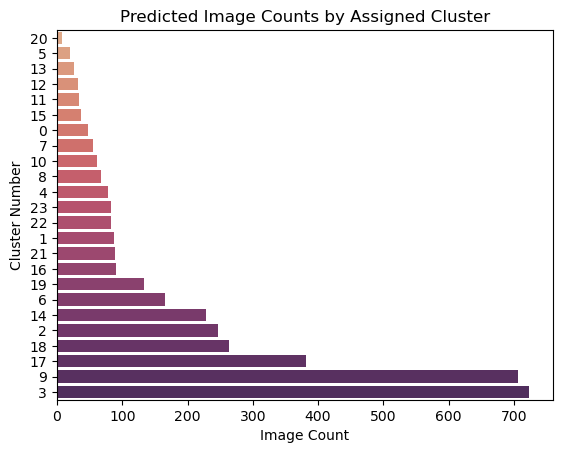

In [32]:
# See the number of images the model assigned to each cluster
clusters = pd.DataFrame(k_pred)
clusters.rename(columns={0:'Cluster Number'}, inplace=True)
clusters = pd.DataFrame(clusters['Cluster Number'].value_counts()).sort_values(by='Cluster Number', axis=0).reset_index()
clusters.rename(columns={'Cluster Number':'Image Count', 'index':'Cluster Number'}, inplace=True)
clusters['Cluster Number'] = clusters['Cluster Number'].astype(str)
sns.barplot(clusters, x='Image Count', y='Cluster Number', palette='flare').set_title('Predicted Image Counts by Assigned Cluster')

Text(0.5, 1.0, 'True Image Counts by Label Number')

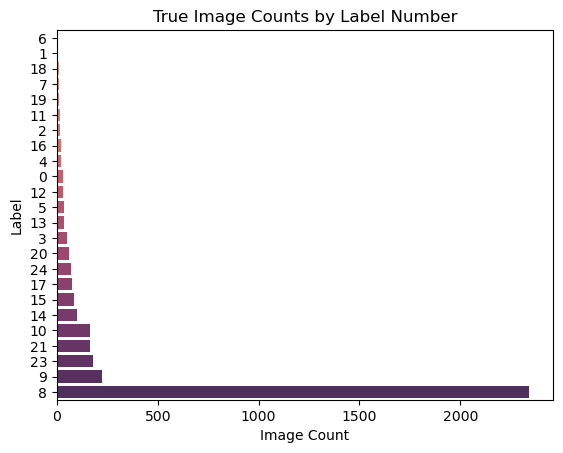

In [33]:
# View the true distribution of the training set for comparison
train_label_counts = pd.DataFrame(train_shuffled['Label'].value_counts()).sort_values(by='Label', axis=0).reset_index()
train_label_counts.rename(columns={'Label':'Image Count', 'index':'Label'}, inplace=True)
train_label_counts['Label'] = train_label_counts['Label'].astype(str)
sns.barplot(train_label_counts, x='Image Count', y='Label', palette='flare', orient='h').set_title('True Image Counts by Label Number')

- Understanding that the labels do not match, this is simply to compare the distribution of image counts, it is easy to see that the clusters are not representative of the true distribution of image types in the training data which K-means predicted on.
- The model divided the images much more evenly among the clusters, failing to recognize the particularly high volume of images associated with ground (true label of 8).
- K-means does not seem reliable for general classifying of this data.

## Dimensionality Reduction with t-SNE

- Reducing the dimensionality and plotting the relationship between groups may help to better understand the data and the results from the K-means model.

In [34]:
# Fit a t-SNE model, reducing the dimensions to 2
tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)
X_tsne = tsne.fit_transform(X_train_2D)

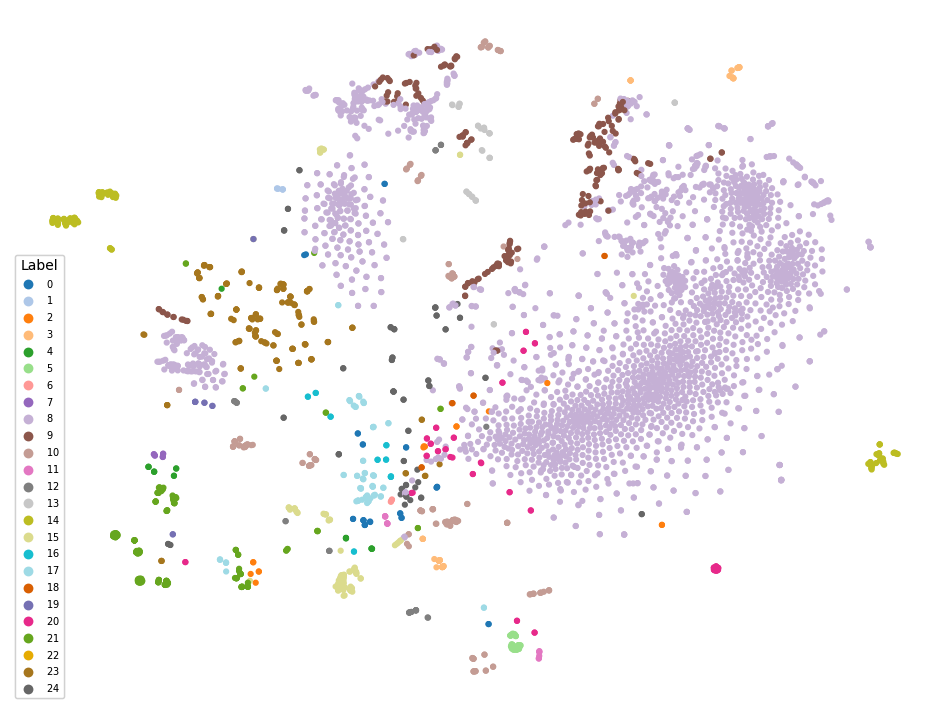

In [35]:
# Plot the label groupings

cmap_t = ListedColormap(np.concatenate([plt.cm.get_cmap('tab20').colors, plt.cm.get_cmap('Dark2').colors]))

fig, ax = plt.subplots(1, 1, figsize=(12,9))

scat_t = ax.scatter(X_tsne[:,0], X_tsne[:,1], s=12, c=y_train, cmap=cmap_t)
legend = ax.legend(*scat_t.legend_elements(num=25), loc="lower left", title="Label", fontsize=7)
ax.add_artist(legend)
ax.set_axis_off()

- The light purple colored points that dominate the plot represent images of the ground. They intermingle with many other colors, as well as having several blobs detached from the main cluster.
- In the center of the plot, in particular, there are a lot of different labels that are close to one another and highly mixed. These would be incredibly difficult to correctly separate.
- K-means can be applied to the t-SNE data to further understand this.

In [36]:
# Fit the t-SNE data using K-means
kmeans = KMeans(n_clusters=k, random_state=42)
k_fit = kmeans.fit(X_tsne)
k_pred = k_fit.predict(X_tsne)
centroids = k_fit.cluster_centers_

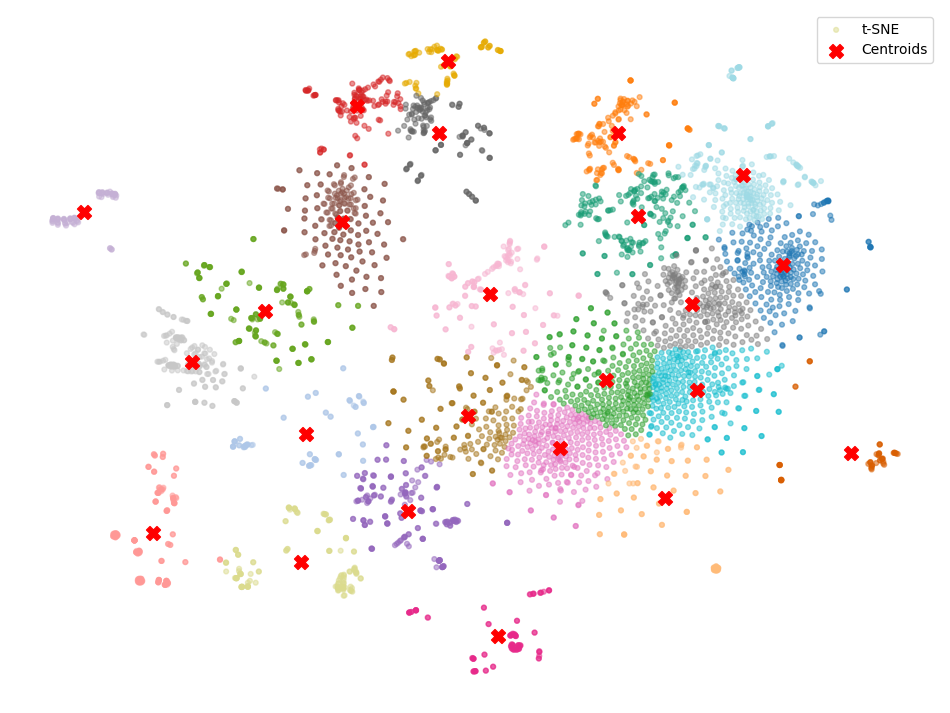

In [37]:
# Plot the data using th
fig, ax = plt.subplots(1, 1, figsize=(12,9))

scat1 = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], s=12, c=k_fit.labels_, cmap=cmap_t, alpha=0.5, label='t-SNE')
scat2 = ax.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=100, c='red', label='Centroids')

ax.legend()
ax.set_axis_off()

- Recognizing that the dimensionality has been immensely reduced, it still is easy to see how difficult separating the data into so many groups can be. The area from the previous plot consisting of the bulk of the ground images has been subdivided into 7 groups here, which is highly erroneous.

Text(0.5, 1.0, 'Image Counts by Cluster')

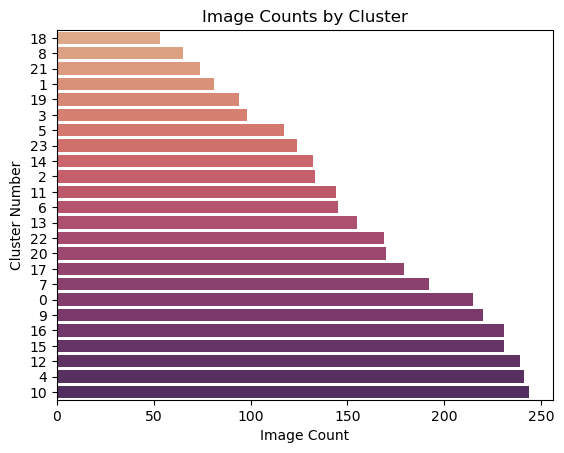

In [51]:
# Look at the distribution of clusters from using the t-SNE data
clusters = pd.DataFrame(k_pred)
clusters.rename(columns={0:'Cluster Number'}, inplace=True)
clusters = pd.DataFrame(clusters['Cluster Number'].value_counts()).sort_values(by='Cluster Number', axis=0).reset_index()
clusters.rename(columns={'Cluster Number':'Image Count', 'index':'Cluster Number'}, inplace=True)
clusters['Cluster Number'] = clusters['Cluster Number'].astype(str)
sns.barplot(clusters, x='Image Count', y='Cluster Number', palette='flare').set_title('Image Counts by Cluster')

- This is not close to the true distribution at all. Too much information is lost by reducing the dimensionality this far.
- However, this was primarily for visualization, not prediction, and now the misclassifications from the K-means model can be better understood.

## Random Forest Classifier

- Random forests are known to generally perform very well for many tasks. This should be a good test for the random forest classifier.

Accuracy: 0.040244


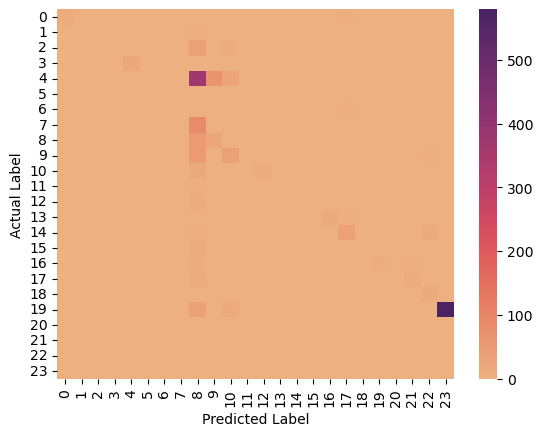

In [39]:
# Build model
rf_clf = RandomForestClassifier(random_state=42)

y_valid_enc = LabelEncoder().fit_transform(y_valid)
        
rf_clf.fit(X_train_2D, y_train)
rf_pred = rf_clf.predict(X_valid_2D)
        
cm = confusion_matrix(y_valid_enc, rf_pred)
acc = accuracy_score(y_valid_enc, rf_pred)

# View the accuracy of the model and confusion matrix of predictions
print(f'Accuracy: {acc:.6f}')
sns.heatmap(cm, annot=False, cmap='flare')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

- Unexpectedly bad results from a random forest.
- Maybe with some dimensionality reduction it will perform better.

### Use PCA with the Random Forest

In [40]:
# Reduce dimensions to the maximum allowable first, for informing subsequent selection
pca = PCA(n_components=len(X_train_2D), random_state=42)
pca.fit(X_train_2D)

PCA(n_components=3746, random_state=42)

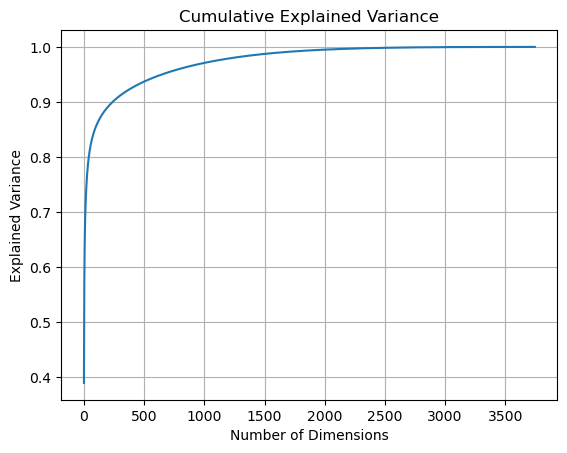

In [41]:
# Plot the explained variance as dimensionality increases
sns.lineplot(np.cumsum(pca.explained_variance_ratio_)).set_title('Cumulative Explained Variance')
plt.xlabel("Number of Dimensions")
plt.ylabel("Explained Variance")
plt.grid()

- Explained variance becomes indistinguishable from 1.0 at about 2500 features, which is far less than the 50,176 features that are currently in the model.
- PCA can be run again using 2500 features, and then implemented with the random forest.

In [42]:
pca_rf = PCA(n_components=2500, random_state=42)

X_train_pca = pca_rf.fit_transform(X_train_2D)
X_valid_pca = pca_rf.transform(X_valid_2D)

Accuracy: 0.045122


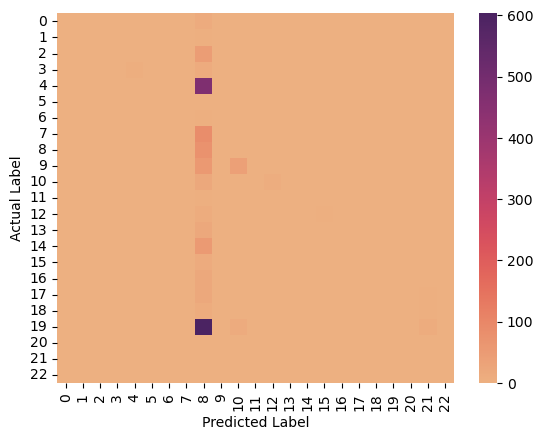

In [43]:
rf_pca = RandomForestClassifier(random_state=42)
        
rf_pca.fit(X_train_pca, y_train)
rf_pred2 = rf_pca.predict(X_valid_pca)
        
cm2 = confusion_matrix(y_valid_enc, rf_pred2)
acc2 = accuracy_score(y_valid_enc, rf_pred2)

print(f'Accuracy: {acc2:.6f}')
sns.heatmap(cm2, annot=False, cmap='flare')
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

- Unfortunately, no luck meaningfully improving the results.

## Convolutional Neural Network (CNN)

- CNNs are especially adept at processing data from images.
- If an appropriate architecture can be created, the CNN should perform immensely better than the previous models.

In [44]:
# Reshape inputs for CNN use
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_valid_cnn = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], X_valid.shape[2], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [53]:
np.random.seed(123)
tf.random.set_seed(123)

cnn = tf.keras.Sequential([
    
    tf.keras.layers.Conv2D(filters=8, kernel_size=(7, 7), padding='same', input_shape=(224, 224, 1), kernel_initializer='he_normal', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), kernel_initializer='he_normal', strides=(2, 2), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), kernel_initializer='he_normal', strides=(2, 2), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), kernel_initializer='he_normal', strides=(1, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_normal', strides=(1, 1), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, kernel_initializer='he_normal', activation='relu'),
    tf.keras.layers.Dense(25, kernel_initializer='glorot_uniform', activation='softmax')
    
])

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 8)       400       
                                                                 
 batch_normalization_5 (Bat  (None, 224, 224, 8)       32        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 54, 54, 16)        3216      
                                                                 
 batch_normalization_6 (Bat  (None, 54, 54, 16)        64        
 chNormalization)                                                
                                                      

In [54]:
# Compile and fit the model
cnn.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
history = cnn.fit(X_train_cnn, y_train, epochs=25, batch_size=32, validation_data=(X_valid_cnn, y_valid))

Epoch 1/25
118/118 [==============================] - 9s 67ms/step - loss: 0.8946 - accuracy: 0.7723 - val_loss: 3.6204 - val_accuracy: 0.0506
Epoch 2/25
118/118 [==============================] - 8s 68ms/step - loss: 0.3060 - accuracy: 0.9130 - val_loss: 3.6571 - val_accuracy: 0.1104
Epoch 3/25
118/118 [==============================] - 8s 64ms/step - loss: 0.2154 - accuracy: 0.9343 - val_loss: 2.7236 - val_accuracy: 0.2939
Epoch 4/25
118/118 [==============================] - 8s 67ms/step - loss: 0.1219 - accuracy: 0.9664 - val_loss: 2.8355 - val_accuracy: 0.3494
Epoch 5/25
118/118 [==============================] - 8s 66ms/step - loss: 0.0853 - accuracy: 0.9696 - val_loss: 2.7838 - val_accuracy: 0.6049
Epoch 6/25
118/118 [==============================] - 8s 67ms/step - loss: 0.1614 - accuracy: 0.9477 - val_loss: 3.3641 - val_accuracy: 0.5445
Epoch 7/25
118/118 [==============================] - 8s 64ms/step - loss: 0.0778 - accuracy: 0.9736 - val_loss: 3.9448 - val_accuracy: 0.4567

<Axes: >

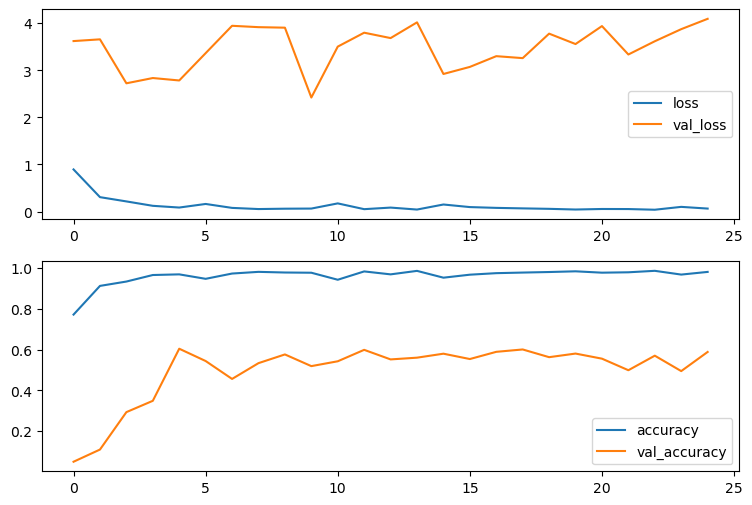

In [55]:
# Plot the training/validation losses and accuracies over the fitting epochs
hist = pd.DataFrame(history.history)

fig, ax1 = plt.subplots(2, 1, figsize=(9,6))

hist[['loss', 'val_loss']].plot(ax=ax1[0])
hist[['accuracy', 'val_accuracy']].plot(ax=ax1[1])

In [56]:
# Check the accuracy of the model on the testing data
test_loss, test_acc = cnn.evaluate(X_test_cnn, y_test)
test_acc

41/41 [==============================] - 1s 18ms/step - loss: 3.9313 - accuracy: 0.4207


0.4206896424293518

- This is much improved over the random forest. However, it is still quite far off from being a useful model.

In [57]:
# Make predictions
test_preds = cnn.predict(X_test_cnn)
predicted_labels = np.argmax(test_preds, axis=1)
incorrect_indices = np.where(y_test != predicted_labels)[0]
incorrect = pd.DataFrame(y_test[incorrect_indices])

41/41 [==============================] - 1s 17ms/step


Text(0.5, 1.0, 'Proportion of All Misclassifications by Label')

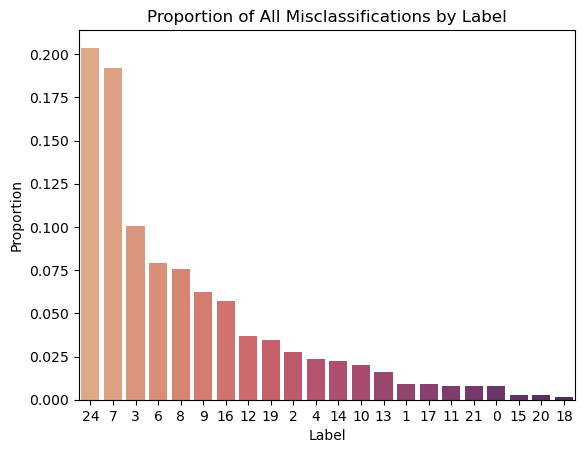

In [58]:
# View which labels were most highly misclassified
misclass = pd.DataFrame(incorrect.value_counts(normalize=True)).reset_index()
misclass.rename(columns={0:'Proportion'}, inplace=True)#.sort_values(by='Proportion', axis=0).reset_index()
misclass['Label'] = misclass['Label'].astype(str)
sns.barplot(misclass, x='Label', y='Proportion', palette='flare').set_title('Proportion of All Misclassifications by Label')

- labels 24 and 7, 'wheel' and 'drt side' respectively, were the most commonly misclassified image types.
- The random forest also predicted 24 at a very high rate when it was an incorrect prediction. Perhaps the wheel might be an accessory to many images while it is not meant to be the focus.

## Findings and Conclusion

- Classifying the Mars Curiosity Rover images is exceptionally difficult. The random forest was the biggest surprise, barely making any correct predictions for a typically robust model.
- It is worth noting the low amount of training data at approximately 6700 observations versus a high number of features at over 50,000. Also, the data are very unevenly distributed among the image categories. These factors could contribute to the overall low performance of the models.
- The featureless landscape likely adds to the challenge of identifying patterns in the images, as do the various zoom levels of the images (image 1 and 2001 above are the same piece of equipment, for example).
- Creating a deeper CNN with more time allotted for training would be an interesting follow on to this analysis.

## References
The following references are given by request of the data source:

- DOI [10.5281/zenodo.1049137](10.5281/zenodo.1049137)
- Kiri L. Wagstaff, You Lu, Alice Stanboli, Kevin Grimes, Thamme Gowda, and Jordan Padams. "Deep Mars: CNN Classification of Mars Imagery for the PDS Imaging Atlas." Proceedings of the Thirtieth Annual Conference on Innovative Applications of Artificial Intelligence, 2018.